# Trabalho Prático 2 – Aprendizado Não Supervisionado  
## Segmentação de Clientes com Algoritmos de Clusterização

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juniors719/customer_personality_clustering/blob/main/customer_segmentation.ipynb)

### Equipe:
* Francisco Djalma Pereira da Silva Júnior - 554222
* Francisco Leudes Bezerra Neto - 552478
* Pablo Vinícius da Silva Araújo - 574229

### Objetivo:
O objetivo principal deste projeto é aplicar, comparar e avaliar o desempenho de três algoritmos de clusterização distintos a um conjunto de dados real. O processo envolve todas as etapas de um projeto de ciência de dados, desde a exploração e pré-processamento dos dados até a aplicação dos modelos e a interpretação dos resultados. Ao final, buscamos identificar segmentos (clusters) de clientes com perfis e comportamentos semelhantes, que possam ser utilizados para direcionar estratégias de marketing mais eficazes.

### Descrição do Conjunto de Dados:
Para este trabalho, foi selecionado o dataset **"Customer Personality Analysis"**, disponível publicamente na plataforma Kaggle.
* **Fonte:** [Kaggle - Customer Personality Analysis](https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis)
* **Amostras:** O dataset original contém **2.240** registros de clientes.
* **Características:** Possui **29** atributos (features) que detalham o perfil de cada consumidor em quatro categorias principais:
    * **Pessoas:** Dados demográficos como ano de nascimento, educação, estado civil e renda.
    * **Produtos:** Gastos em diferentes categorias de produtos (vinhos, carnes, frutas, etc.).
    * **Promoções:** Engajamento dos clientes com campanhas de marketing anteriores.
    * **Lugar:** Canais de compra utilizados pelos clientes (loja física, site, catálogo).

Este conjunto de dados é ideal para a tarefa de clusterização, pois não possui rótulos predefinidos (variável alvo), característica típica de problemas de aprendizado não supervisionado. A riqueza de atributos comportamentais e demográficos torna possível a identificação de segmentos relevantes.

### Algoritmos Utilizados

- **K-Means:** Rápido e eficiente para grandes datasets; assume clusters esféricos e de tamanho similar.
- **Hierárquico (Aglomerativo):** Permite análise mais interpretável via dendrograma; não requer definição prévia do número de clusters.
- **DBSCAN:** Identifica clusters de formatos arbitrários e detecta outliers naturalmente.

### Pipeline do Projeto
1. Importação e visualização inicial dos dados
2. Limpeza de dados e engenharia de atributos
3. Análise exploratória e identificação de outliers
4. Pré-processamento (normalização e codificação)
5. Aplicação dos algoritmos de clusterização
6. Avaliação e comparação dos modelos
7. Visualização com PCA e t-SNE
8. Perfilamento e interpretação dos clusters

### Divisão de Tarefas:

| Etapa                                          | Djalma | Leudes | Pablo |
|------------------------------------------------|:------:|:------:|:-----:|
| Escolha do dataset e definição do problema     |   ✔    |   ✔    |   ✔   |
| Importação e visualização inicial dos dados    |        |   ✔    |       |
| Limpeza e engenharia de features               |   ✔    |        |       |
| Análise exploratória e remoção de outliers     |        |        |   ✔   |
| Pré-processamento (encoding e scaling)         |   ✔    |        |   ✔   |
| Modelagem com K-Means                          |   ✔    |        |       |
| Modelagem com Clusterização Hierárquica        |        |   ✔    |       |
| Modelagem com DBSCAN                           |        |        |   ✔   |
| Avaliação dos modelos                          |   ✔    |   ✔    |   ✔   |
| Visualização dos clusters (PCA e t-SNE)        |   ✔    |        |       |
| Conclusão e perfilamento                       |   ✔    |   ✔    |   ✔   |


# Importação de bibliotecas


In [241]:
# Importação das bibliotecas para manipulação de dados, matemática e visualização
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importação das ferramentas de Machine Learning do Scikit-learn que serão usadas
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Importação de bibliotecas para ajudar com a visualização e avisos
import warnings
from scipy.cluster.hierarchy import dendrogram, linkage

# --- CONFIGURAÇÕES GERAIS ---
# Ignorar avisos de bibliotecas para um output mais limpo
warnings.filterwarnings("ignore")
# Define um estilo visual padrão para os gráficos
sns.set_style("whitegrid")


import missingno as mn

#kelbowvisualizer
from yellowbrick.cluster import KElbowVisualizer

# Leitura do dataset

In [242]:
try:
    # O arquivo 'marketing_campaign.csv' deve estar na mesma pasta que o seu notebook
    url = "https://raw.githubusercontent.com/juniors719/customer_personality_clustering/refs/heads/main/marketing_campaign.csv"
    df = pd.read_csv(url, sep='\t')
    print("--- Dataset Carregado com Sucesso! ---")
    print(f"O dataset tem {df.shape[0]} linhas e {df.shape[1]} colunas.")
except FileNotFoundError:
    print("ERRO: O arquivo 'marketing_campaign.csv' não foi encontrado.")
    print("Por favor, certifique-se de que o arquivo está na mesma pasta que o seu notebook.")

--- Dataset Carregado com Sucesso! ---
O dataset tem 2240 linhas e 29 colunas.


# Primeira análise do dataset

In [243]:
# 1. Visualização das primeiras linhas do dataset
print("\n--- Visualizando as 5 primeiras linhas do dataset: ---")
display(df.head())


--- Visualizando as 5 primeiras linhas do dataset: ---


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


### Verificação de Tipos de Dados e Contagem de Nulos

O `.info()` nos dá uma visão rápida sobre os tipos de dados e a presença de valores nulos.

In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

### Estatísticas Descritivas (Numéricas)

O `.describe()` resume as principais métricas estatísticas das colunas numéricas.

In [245]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
ID,2240.0,5592.159821,3246.662198,0.0,2828.25,5458.5,8427.75,11191.0
Year_Birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
Income,2216.0,52247.251354,25173.076661,1730.0,35303.00,51381.5,68522.00,666666.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0


### Contagem de Valores Nulos por Coluna

A presença de dados ausentes é um dos problemas mais comuns em projetos de ciência de dados. É crucial identificá-los e tratá-los corretamente, pois a maioria dos algoritmos de Machine Learning não funciona com valores nulos.

**O Impacto dos Dados Ausentes:**

- **Redução do Poder Estatístico:** A ausência de dados diminui o tamanho da amostra, o que pode enfraquecer os resultados de testes estatísticos e a confiança nos modelos.
- **Viés nos Resultados:** Se os dados não estiverem faltando de forma completamente aleatória, a sua ausência pode introduzir um viés significativo. Por exemplo, se pessoas com renda mais baixa tendem a não informar sua renda, qualquer análise sobre o impacto da renda no consumo será distorcida.
- **Problemas Técnicos:** Como mencionado, algoritmos como k-Means param ou geram erros ao encontrar valores nulos.

Vamos agora visualizar detalhadamente onde estão os nossos dados ausentes.

In [246]:
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percentage = (df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending=False)
    return pd.concat([total, percentage], axis=1, keys=['Total', 'Porcentagem'])

print("\n\n--- Análise de Dados Ausentes por Coluna ---")
missing_values = missing_data(df)
display(missing_values.style.background_gradient(cmap='Reds'))



--- Análise de Dados Ausentes por Coluna ---


,Total,Porcentagem
Income,24,1.071429
ID,0,0.000000
Year_Birth,0,0.000000
Education,0,0.000000
Marital_Status,0,0.000000
Kidhome,0,0.000000
Teenhome,0,0.000000
Dt_Customer,0,0.000000
Recency,0,0.000000
MntWines,0,0.000000




--- Matriz de Valores Ausentes ---


<Axes: >

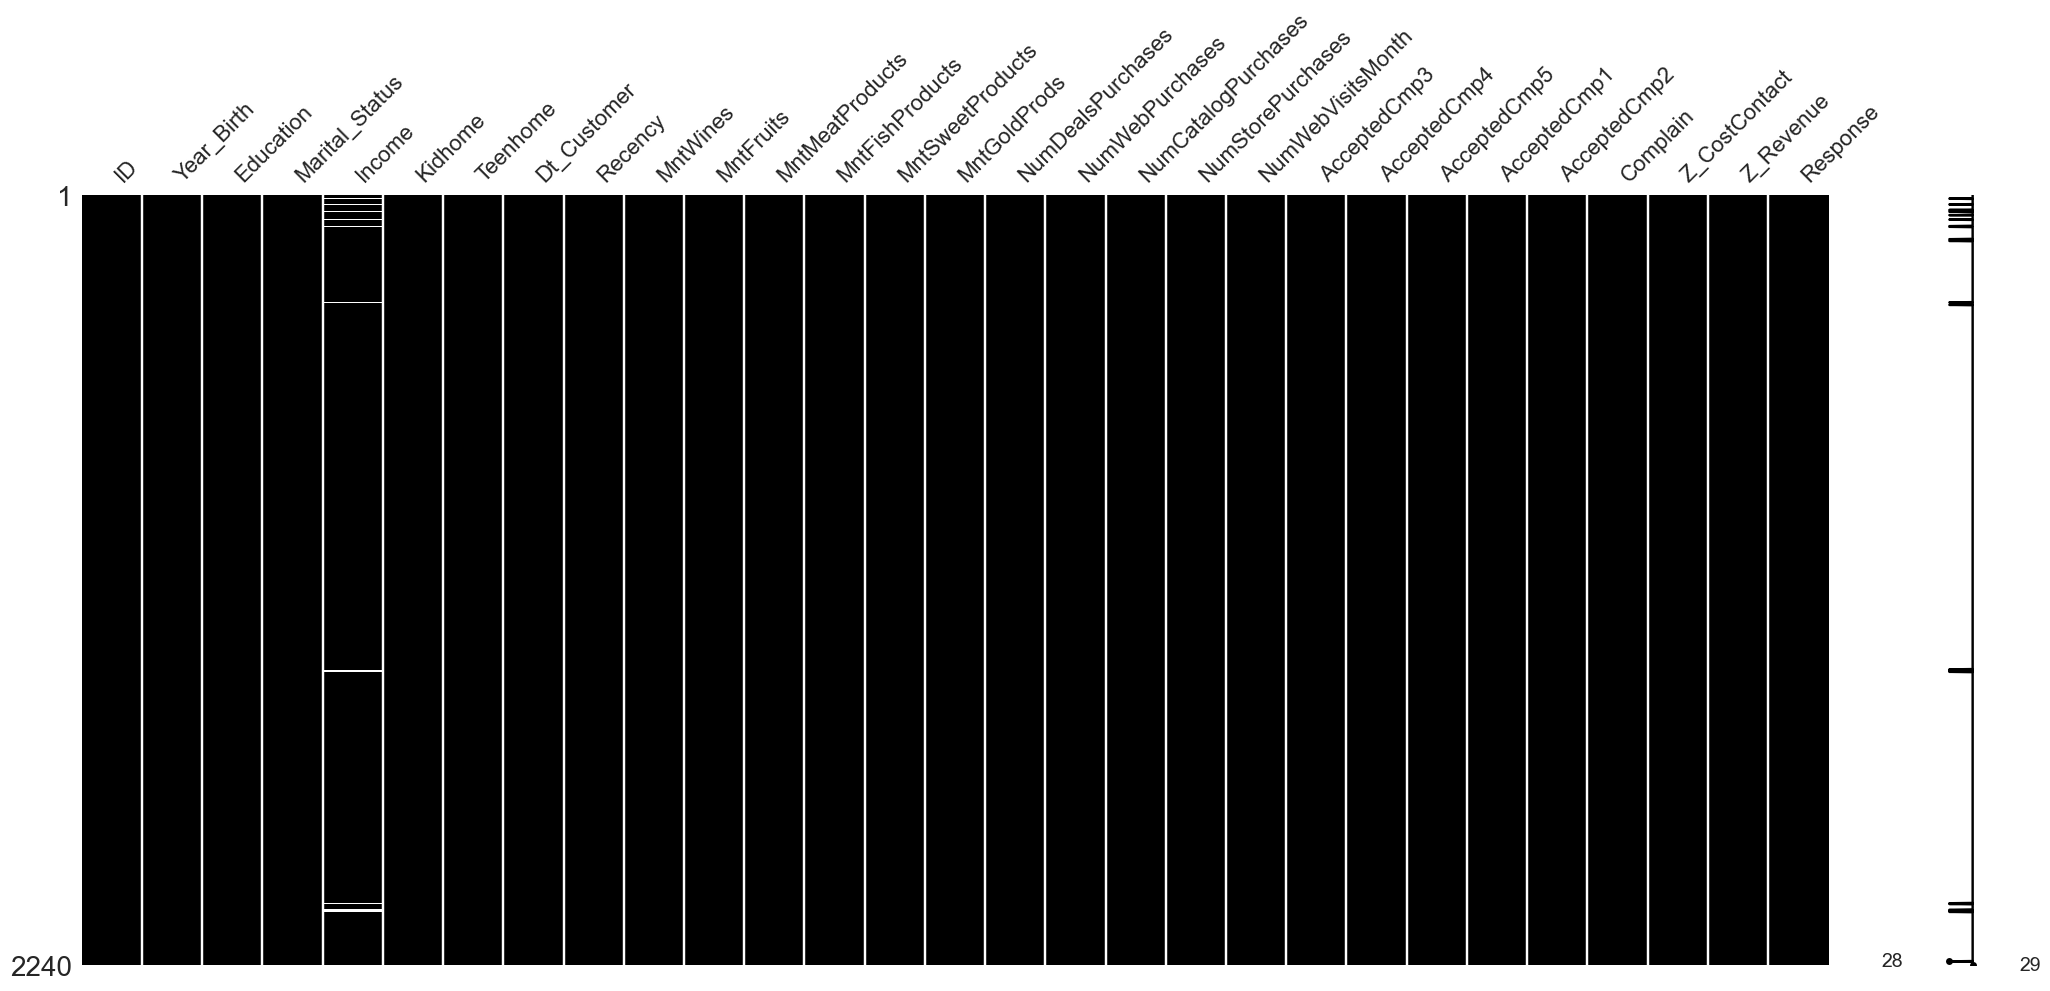

In [247]:
# Visualizar a matriz de valores ausentes
print("\n\n--- Matriz de Valores Ausentes ---")
mn.matrix(df,color = (0,0,0))

###  Verificação de Linhas Duplicadas

In [248]:
num_duplicados = df.duplicated().sum()
print(f"Número de linhas duplicadas encontradas: {num_duplicados}")

Número de linhas duplicadas encontradas: 0


### Contagem de Valores Únicos (Cardinalidade) por Coluna

O `.nunique()` é essencial para identificar colunas constantes.

In [249]:
display(df.nunique())

ID                     2240
Year_Birth               59
Education                 5
Marital_Status            8
Income                 1974
Kidhome                   3
Teenhome                  3
Dt_Customer             663
Recency                 100
MntWines                776
MntFruits               158
MntMeatProducts         558
MntFishProducts         182
MntSweetProducts        177
MntGoldProds            213
NumDealsPurchases        15
NumWebPurchases          15
NumCatalogPurchases      14
NumStorePurchases        14
NumWebVisitsMonth        16
AcceptedCmp3              2
AcceptedCmp4              2
AcceptedCmp5              2
AcceptedCmp1              2
AcceptedCmp2              2
Complain                  2
Z_CostContact             1
Z_Revenue                 1
Response                  2
dtype: int64

A análise de cardinalidade revelou que as colunas `Z_CostContact` e `Z_Revenue` possuem apenas **1 valor único**. Elas são constantes e serão removidas na etapa de limpeza por não adicionarem informação útil.

### Conclusão da Análise Diagnóstica

A partir da análise diagnóstica, podemos extrair as seguintes conclusões que guiarão nosso próximo passo:

* **Estrutura Confirmada:** O dataset possui **2240 linhas** e **29 colunas**.
* **Dados Ausentes Identificados:** O diagnóstico confirma que a única coluna com valores faltantes é a `Income`, com **24 registros nulos**.
* **Sem Duplicatas:** Não há linhas duplicadas no dataset.
* **Colunas Constantes:** As colunas `Z_CostContact` e `Z_Revenue` possuem apenas um valor único, indicando que não contribuem com informação útil para a clusterização. Elas serão removidas na etapa de limpeza.
* **Necessidade de Pré-processamento:** O dataset contém uma mistura de tipos de dados (numéricos e de texto) que exigirá tratamento (normalização e codificação) antes da modelagem.

# Data Cleaning

In [250]:
df_clean = df.copy()

### Preenchimento de Dados Ausentes

Para lidar com os dados ausentes, uma abordagem comum é preencher os valores nulos com a mediana da coluna correspondente. Isso é especialmente útil para colunas numéricas, como a `Income`, onde a média pode fornecer uma estimativa razoável do valor ausente sem introduzir viés significativo.

In [251]:
income_median = df_clean['Income'].median()
df_clean['Income'].fillna(income_median, inplace=True)
print(f"Valores nulos em 'Income' após imputação: {df_clean['Income'].isnull().sum()}")

Valores nulos em 'Income' após imputação: 0


### Engenharia de Features
A engenharia de features é uma etapa crucial no pré-processamento de dados, onde transformamos e criamos novas variáveis a partir das existentes para melhorar o desempenho dos modelos de Machine Learning.

* **`Idade`**: É uma variável demográfica muito mais intuitiva e diretamente interpretável do que o ano de nascimento.
* **`Gasto_Total`**: Consolida todos os gastos em uma única métrica poderosa que representa o valor total de compra de cada cliente.
* **`Tempo_de_Cliente_dias`**: Mede a longevidade do relacionamento do cliente com a empresa, um excelente indicador de lealdade.
* **`Total_Filhos`** e **`Possui_Filhos`**: Simplificam a estrutura familiar, permitindo analisar de forma direta e eficaz as diferenças de comportamento entre clientes que são pais e os que não são.

In [252]:
# CRIAÇÃO DE FEATURES

# Criação da Feature 'Age' a partir do ano de nascimento
df_clean['Age'] = 2025 - df_clean['Year_Birth']

# Criação da Feature 'Total_Spent' que soma os gastos em diferentes categorias
df_clean['Total_Spent'] = df_clean[[col for col in df.columns if 'Mnt' in col]].sum(axis=1)

# Conversão da coluna 'Dt_Customer' para o formato datetime
df_clean['Dt_Customer'] = pd.to_datetime(df_clean['Dt_Customer'], dayfirst=True)

# Criação da Feature 'Customer_Tenure' que calcula o tempo de relacionamento com o cliente
df_clean['Customer_Tenure'] = (pd.to_datetime('2025-07-06') - df_clean['Dt_Customer']).dt.days # Usando a data da entrega

# Criação da Feature 'Children' que soma as colunas 'Kidhome' e 'Teenhome'
df_clean['Children'] = df_clean['Kidhome'] + df_clean['Teenhome']

# Criação da Feature 'Is_Parent' que indica se o cliente é pai/mãe
df_clean['Is_Parent'] = np.where(df_clean['Children'] > 0, 1, 0)

Para otimizar nosso dataset, vamos agora simplificar algumas colunas categóricas. O objetivo é agrupar categorias que têm um significado semelhante ou que são muito raras, reduzindo o "ruído" nos dados e tornando os padrões mais claros para os algoritmos.

* **`Estado_Civil`**: As diversas categorias serão agrupadas em duas classes principais: `In_Relationship` (para `Married` e `Together`) e `Single` (para as demais). Esta simplificação captura a principal informação sobre a estrutura do domicílio do cliente (vive com um parceiro ou não).
* **`Escolaridade`**: Os diferentes níveis de educação serão consolidados em três grupos mais amplos e significativos: `Undergraduate`, `Graduate` e `Postgraduate`.
* **`Tamanho_Familia`**: Por fim, criaremos uma nova feature combinando o `Estado_Civil` simplificado com o número de filhos (`Total_Filhos`), resultando em uma única e poderosa variável que descreve a composição do lar do cliente.


In [253]:
# SIMPLIFICAÇÃO DE FEATURES

# Simplificação da coluna 'Marital_Status', a fim de agrupar estados civis semelhantes.
df_clean['Marital_Status'] = df_clean['Marital_Status'].replace({
    'Married': 'In_Relationship',
    'Together': 'In_Relationship',
    'Single': 'Single',
    'Divorced': 'Single',
    'Widow': 'Single',
    'Alone': 'Single',
    'Absurd': 'Single',
    'YOLO': 'Single'
})

# Simplificação da coluna 'Education', agrupando níveis de escolaridade semelhantes.
df_clean['Education'] = df_clean['Education'].replace({
    'Basic': 'Undergraduate', '2n Cycle': 'Undergraduate', 'Graduation': 'Graduate',
    'Master': 'Postgraduate', 'PhD': 'Postgraduate'
})

# Criação de Feature Combinada
df_clean['Family_Size'] = df_clean['Marital_Status'].map({'Single': 1, 'In_Relationship': 2}) + df_clean['Children']

Após a criação de novas features mais informativas, algumas das colunas originais se tornaram redundantes ou são irrelevantes para a modelagem. Para criar um dataset final mais limpo e focado, vamos remover os seguintes grupos de colunas:

* **Identificadores:** A coluna `ID` é apenas um identificador único de cliente e não contém informação sobre seu comportamento.
* **Features Redundantes:** As colunas `Year_Birth` e `Dt_Customer` já foram utilizadas para criar `Idade` e `Tempo_de_Cliente_dias`, respectivamente. Da mesma forma, `Kidhome` e `Teenhome` foram consolidadas na feature `Total_Filhos`. Manter as originais apenas adicionaria informação repetida.
* **Features Constantes:** As colunas `Z_CostContact` e `Z_Revenue` foram identificadas na análise diagnóstica como constantes (possuem o mesmo valor para todos os clientes) e, portanto, não têm poder preditivo.

A remoção dessas colunas resultará em um dataset mais enxuto e eficiente para a etapa de clusterização.

In [254]:
# REMOÇÃO DE FEATURES INÚTEIS

to_drop = ['ID', 'Year_Birth', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'Kidhome', 'Teenhome']
df_clean.drop(columns=to_drop, inplace=True)
print(f"\nColunas removidas do dataset: {to_drop}")


Colunas removidas do dataset: ['ID', 'Year_Birth', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'Kidhome', 'Teenhome']


Para facilitar a leitura, a interpretação dos gráficos e a análise dos resultados, todas as colunas do dataframe `df_clean` foram traduzidas para o português. Esta etapa melhora a clareza do notebook e torna a comunicação dos insights mais direta e intuitiva.

In [255]:
# --- TRADUÇÃO DAS COLUNAS PARA PORTUGUÊS ---

# Dicionário mapeando os nomes originais para os nomes em português
mapeamento_nomes = {
    'Education': 'Escolaridade',
    'Marital_Status': 'Estado_Civil',
    'Income': 'Renda_Anual',
    'Recency': 'Dias_Ultima_Compra',
    'MntWines': 'Gasto_Vinhos',
    'MntFruits': 'Gasto_Frutas',
    'MntMeatProducts': 'Gasto_Carnes',
    'MntFishProducts': 'Gasto_Peixes',
    'MntSweetProducts': 'Gasto_Doces',
    'MntGoldProds': 'Gasto_Ouro',
    'NumDealsPurchases': 'Compras_com_Desconto',
    'NumWebPurchases': 'Compras_pela_Web',
    'NumCatalogPurchases': 'Compras_por_Catalogo',
    'NumStorePurchases': 'Compras_na_Loja',
    'NumWebVisitsMonth': 'Visitas_no_Site_Mes',
    'AcceptedCmp3': 'Aceitou_Campanha_3',
    'AcceptedCmp4': 'Aceitou_Campanha_4',
    'AcceptedCmp5': 'Aceitou_Campanha_5',
    'AcceptedCmp1': 'Aceitou_Campanha_1',
    'AcceptedCmp2': 'Aceitou_Campanha_2',
    'Complain': 'Reclamou_2_Anos',
    'Response': 'Aceitou_Ultima_Campanha',
    'Age': 'Idade',
    'Total_Spent': 'Gasto_Total',
    'Customer_Tenure': 'Tempo_de_Cliente_dias',
    'Children': 'Total_Filhos',
    'Is_Parent': 'Possui_Filhos',
    'Family_Size': 'Tamanho_Familia'
}

df_clean.rename(columns=mapeamento_nomes, inplace=True)

print("\n--- Colunas traduzidas para o português ---")
print("Visualizando o dataframe com os novos nomes de colunas:")
display(df_clean.head())


--- Colunas traduzidas para o português ---
Visualizando o dataframe com os novos nomes de colunas:


,Escolaridade,Estado_Civil,Renda_Anual,Dias_Ultima_Compra,Gasto_Vinhos,Gasto_Frutas,Gasto_Carnes,Gasto_Peixes,Gasto_Doces,Gasto_Ouro,...,Aceitou_Campanha_1,Aceitou_Campanha_2,Reclamou_2_Anos,Aceitou_Ultima_Campanha,Idade,Gasto_Total,Tempo_de_Cliente_dias,Total_Filhos,Possui_Filhos,Tamanho_Familia
0,Graduate,Single,58138.0,58,635,88,546,172,88,88,...,0,0,0,1,68,1617,4688,0,0,1
1,Graduate,Single,46344.0,38,11,1,6,2,1,6,...,0,0,0,0,71,27,4138,2,1,3
2,Graduate,In_Relationship,71613.0,26,426,49,127,111,21,42,...,0,0,0,0,60,776,4337,0,0,2
3,Graduate,In_Relationship,26646.0,26,11,4,20,10,3,5,...,0,0,0,0,41,53,4164,1,1,3
4,Postgraduate,In_Relationship,58293.0,94,173,43,118,46,27,15,...,0,0,0,0,44,422,4186,1,1,3


# Análise Exploratória

Agora que nossos dados estão limpos e enriquecidos, vamos iniciar a análise exploratória visual. Começaremos com uma **análise univariada**, ou seja, analisando uma variável de cada vez para entender suas características individuais.

### Análise Univariada

Usaremos **histogramas** para visualizar a distribuição de duas das nossas features mais importantes: `Idade` e `Gasto_Total`.

* **Histograma de Idade:** Nos ajudará a entender a faixa etária predominante dos nossos clientes. Existem mais clientes jovens, de meia-idade ou mais velhos? A distribuição é uniforme ou concentrada em algum grupo?
* **Histograma de Gasto Total:** Revelará a distribuição do poder de compra. É provável que encontremos uma **assimetria à direita**, onde a maioria dos clientes tem um gasto moderado e uma minoria de "high-rollers" gasta valores muito mais altos.

Compreender essas distribuições é o primeiro passo para identificar os diferentes perfis de clientes que compõem nossa base.

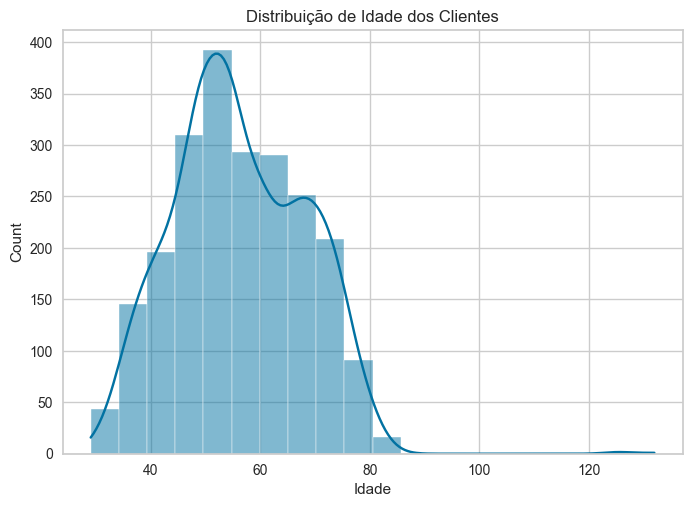

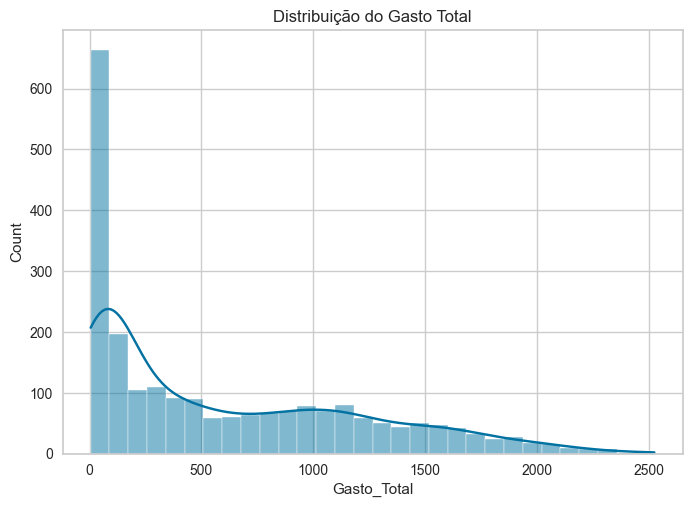

In [256]:
# Verificar distribuição de idade
sns.histplot(df_clean['Idade'], bins=20, kde=True)
plt.title('Distribuição de Idade dos Clientes')
plt.show()

# Gasto Total
sns.histplot(df_clean['Gasto_Total'], bins=30, kde=True)
plt.title('Distribuição do Gasto Total')
plt.show()

### Análise Visual para Identificação de Outliers

Para aprofundar nossa análise e preparar os dados para a clusterização, é essencial identificar a presença de **outliers**. Outliers são pontos de dados que se desviam significativamente do resto do conjunto e podem distorcer os resultados de algoritmos sensíveis à distância, como o k-Means.

A ferramenta visual mais eficaz para esta tarefa é o **Boxplot**. Ele nos permite visualizar:
* A **mediana** (a linha central).
* O **intervalo interquartil (IQR)** (a "caixa", que contém 50% dos dados centrais).
* Os **"bigodes" (whiskers)**, que representam o alcance esperado dos dados.
* E, mais importante, os **pontos individuais fora dos bigodes**, que são os nossos potenciais outliers.

Vamos gerar boxplots para as nossas principais variáveis contínuas: `Renda_Anual`, `Idade` e `Gasto_Total`.

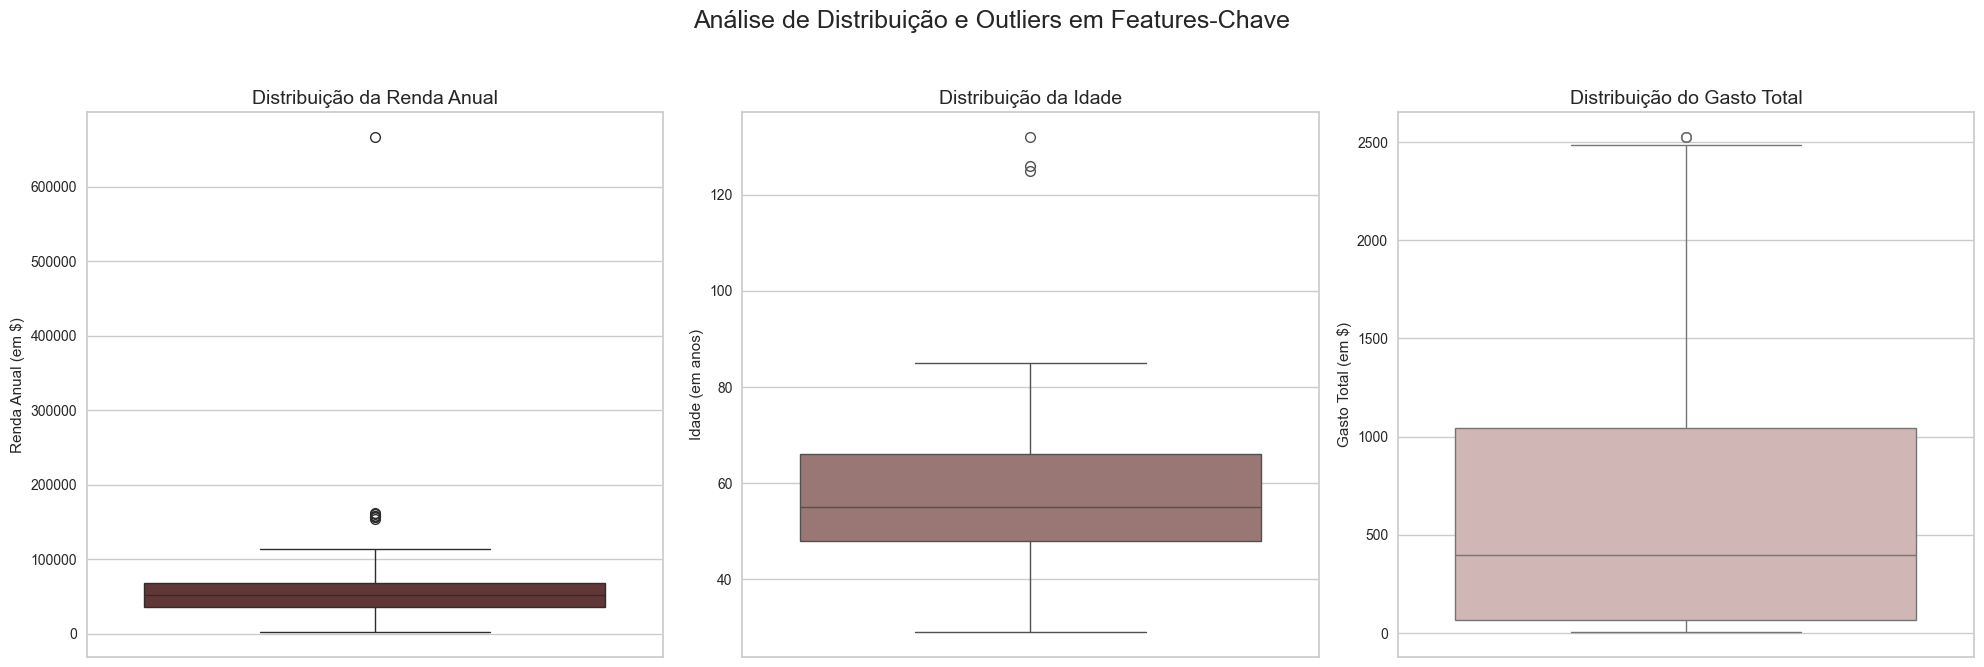

In [257]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('Análise de Distribuição e Outliers em Features-Chave', fontsize=18)

# Usaremos a paleta de cores que definimos no início
PALETTE = ["#682F2F", "#9E726F", "#D6B2B1"]

# Gráfico 1: Boxplot da Renda Anual
sns.boxplot(ax=axes[0], data=df_clean, y='Renda_Anual', color=PALETTE[0])
axes[0].set_title('Distribuição da Renda Anual', fontsize=14)
axes[0].set_ylabel('Renda Anual (em $)')

# Gráfico 2: Boxplot da Idade
sns.boxplot(ax=axes[1], data=df_clean, y='Idade', color=PALETTE[1])
axes[1].set_title('Distribuição da Idade', fontsize=14)
axes[1].set_ylabel('Idade (em anos)')

# Gráfico 3: Boxplot do Gasto Total
sns.boxplot(ax=axes[2], data=df_clean, y='Gasto_Total', color=PALETTE[2])
axes[2].set_title('Distribuição do Gasto Total', fontsize=14)
axes[2].set_ylabel('Gasto Total (em $)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Remoção de Outliers

A análise visual da etapa anterior, especialmente através dos boxplots, confirmou a presença de valores extremos (outliers) nas colunas `Renda_Anual` e `Idade`. Estes pontos, embora poucos, podem distorcer significativamente o cálculo das distâncias e a formação dos clusters, levando a um modelo menos preciso e representativo da maioria dos clientes.

Para mitigar esse risco, vamos remover esses registros do nosso dataset. Adotaremos os seguintes critérios de corte:
* **Renda Anual:** Manteremos apenas clientes com renda inferior a 200.000.
* **Idade:** Manteremos apenas clientes com idade inferior a 90 anos.

Esta limpeza resultará em um conjunto de dados mais robusto e preparado para a etapa de modelagem.

In [258]:
# --- REMOÇÃO DE OUTLIERS ---

# Guardamos o número de linhas antes da remoção para verificar o impacto
linhas_antes = df_clean.shape[0]

# Filtramos o dataframe para manter apenas os clientes com Renda_Anual < 200.000 e Idade < 90
# Usamos .copy() para garantir que estamos criando um novo dataframe independente
df_sem_outliers = df_clean[(df_clean['Renda_Anual'] < 200000) & (df_clean['Idade'] < 90)].copy()

linhas_depois = df_sem_outliers.shape[0]
outliers_removidos = linhas_antes - linhas_depois

print("--- Remoção de Outliers Concluída ---")
print(f"Número de linhas original: {linhas_antes}")
print(f"Número de linhas após remover outliers: {linhas_depois}")
print(f"Total de outliers removidos: {outliers_removidos}")

# O nosso novo dataframe de trabalho agora é o 'df_sem_outliers'

--- Remoção de Outliers Concluída ---
Número de linhas original: 2240
Número de linhas após remover outliers: 2236
Total de outliers removidos: 4


### Análise de Correlação entre Features-Chave

Para finalizar nossa análise exploratória, vamos investigar a **correlação linear** entre as principais variáveis numéricas do nosso conjunto de dados. A correlação mede a força e a direção da relação entre duas variáveis.

Usaremos um **mapa de calor (heatmap)** para visualizar a matriz de correlação. Esta é uma forma gráfica e intuitiva de identificar rapidamente quais variáveis se movem juntas.

**Como interpretar o mapa de calor:**
* **Cores Quentes (próximas ao vermelho - valor próximo de +1):** Indicam uma **correlação positiva forte**. Quando uma variável aumenta, a outra tende a aumentar também. Esperamos ver isso entre `Renda_Anual` e `Gasto_Total`.
* **Cores Frias (próximas ao azul - valor próximo de -1):** Indicam uma **correlação negativa forte**. Quando uma variável aumenta, a outra tende a diminuir.
* **Cores Neutras (próximas ao branco/cinza - valor próximo de 0):** Indicam pouca ou nenhuma correlação linear.

Esta análise nos ajudará a entender as relações subjacentes no comportamento dos clientes antes de aplicarmos os algoritmos de clusterização.

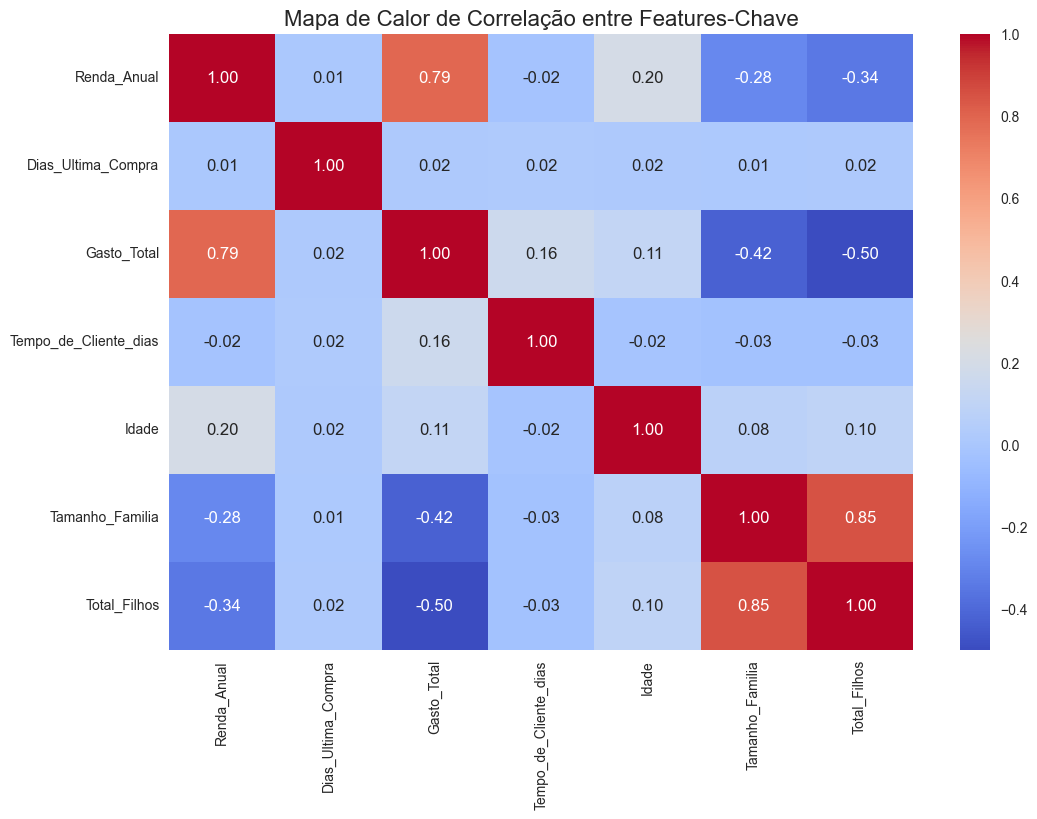

In [259]:
# --- MAPA DE CALOR DE CORRELAÇÃO ---

# Selecionando as colunas numéricas mais relevantes para a correlação
# Usamos o dataframe já sem outliers e com colunas em português
cols_para_corr = [
    'Renda_Anual', 'Dias_Ultima_Compra', 'Gasto_Total', 
    'Tempo_de_Cliente_dias', 'Idade', 'Tamanho_Familia', 'Total_Filhos', 
]

# Calculando a matriz de correlação
matriz_corr = df_sem_outliers[cols_para_corr].corr()

# Criando o mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(
    matriz_corr, 
    annot=True,     # Mostra os valores de correlação no gráfico
    fmt=".2f",      # Formata os números para duas casas decimais
    cmap='coolwarm' # Paleta de cores: quente para positivo, frio para negativo
)
plt.title('Mapa de Calor de Correlação entre Features-Chave', fontsize=16)
plt.show()

* **Correlação Positiva Forte (Renda vs. Gasto):** A observação mais clara é a forte correlação positiva (aproximadamente **+0.79**) entre `Renda_Anual` e `Gasto_Total`. Isso confirma a hipótese intuitiva de que clientes com maior renda tendem a gastar mais. Esta será, provavelmente, uma das variáveis mais importantes para a segmentação dos nossos clientes.

* **Correlação Negativa (Filhos vs. Gasto):** Existe uma correlação negativa moderada (aproximadamente **-0.50**) entre `Total_Filhos` e `Gasto_Total`. Isso sugere que, em geral, clientes com mais filhos tendem a ter um gasto total menor nos produtos da nossa loja, possivelmente por terem outras prioridades financeiras.

* **Correlação Moderada (Idade e Tempo de Cliente):** A `Idade` e o `Tempo_de_Cliente_dias` também mostram uma correlação positiva com o `Gasto_Total`. Isso indica que clientes mais velhos e mais leais (com mais tempo de casa) tendem a gastar mais.

* **Pouca Correlação (Recência):** A variável `Dias_Ultima_Compra` (Recência) parece ter uma correlação muito fraca com as outras variáveis, sugerindo que o tempo desde a última compra não está fortemente ligado de forma linear à renda ou ao gasto total nesta visão geral.

# Pré-processamento

### Label Encoding
Converteremos as variáveis categóricas remanescentes (`Escolaridade` e `Estado_Civil`) em representações numéricas, pois os algoritmos de clusterização não processam texto.

In [260]:
# --- PASSO 4: EXECUÇÃO DO ENCODING E SCALING ---

# Criamos uma cópia do dataframe já limpo para esta etapa final
df_processed = df_sem_outliers.copy()

# 1. ENCODING DE VARIÁVEIS CATEGÓRICAS
# Seleciona as colunas de texto (tipo 'object')
categorical_cols = df_processed.select_dtypes(include='object').columns

print("--- Codificando as seguintes colunas categóricas: ---")
print(categorical_cols)

# Aplica o LabelEncoder para transformar texto em números
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])

--- Codificando as seguintes colunas categóricas: ---
Index(['Escolaridade', 'Estado_Civil'], dtype='object')


### Normalização

Padronizar todas as colunas para que tenham média 0 e desvio padrão 1. Isso evita que variáveis com valores grandes (como Renda_Anual) dominem o processo de clusterização.

In [261]:
# 2. NORMALIZAÇÃO (STANDARD SCALING)
# Instancia o Scaler
scaler = StandardScaler()

# Treina o scaler e transforma o dataframe
scaled_features = scaler.fit_transform(df_processed)

# Converte o array de volta para um dataframe do pandas com os nomes das colunas
# Este é o nosso dataframe final e pronto para a modelagem!
df_ready = pd.DataFrame(scaled_features, columns=df_processed.columns)

In [262]:
# --- RESULTADO DA ETAPA ---
print("\n--- Dataset 100% pronto para a clusterização ---")
print("Todas as features são numéricas e estão na mesma escala.")
display(df_ready.head())


--- Dataset 100% pronto para a clusterização ---
Todas as features são numéricas e estão na mesma escala.


,Escolaridade,Estado_Civil,Renda_Anual,Dias_Ultima_Compra,Gasto_Vinhos,Gasto_Frutas,Gasto_Carnes,Gasto_Peixes,Gasto_Doces,Gasto_Ouro,...,Aceitou_Campanha_1,Aceitou_Campanha_2,Reclamou_2_Anos,Aceitou_Ultima_Campanha,Idade,Gasto_Total,Tempo_de_Cliente_dias,Total_Filhos,Possui_Filhos,Tamanho_Familia
0,-0.89438,1.347635,0.288947,0.306856,0.983228,1.554170,1.679746,2.461068,1.475396,0.845669,...,-0.262362,-0.116616,-0.095001,2.386338,1.016868,1.680176,1.529793,-1.264308,-1.584362,-1.758810
1,-0.89438,1.347635,-0.262003,-0.383971,-0.871064,-0.636431,-0.713455,-0.650414,-0.631638,-0.729742,...,-0.262362,-0.116616,-0.095001,-0.419052,1.273264,-0.962202,-1.191143,1.395139,0.631169,0.445618
2,-0.89438,-0.742041,0.918423,-0.798467,0.362159,0.572177,-0.177201,1.344595,-0.147262,-0.038098,...,-0.262362,-0.116616,-0.095001,-0.419052,0.333146,0.282541,-0.206659,-1.264308,-1.584362,-0.656596
3,-0.89438,-0.742041,-1.182183,-0.798467,-0.871064,-0.560893,-0.651409,-0.503991,-0.583200,-0.748954,...,-0.262362,-0.116616,-0.095001,-0.419052,-1.290693,-0.918994,-1.062517,0.065416,0.631169,0.445618
4,0.57070,-0.742041,0.296187,1.550344,-0.389661,0.421101,-0.217088,0.154911,-0.001950,-0.556831,...,-0.262362,-0.116616,-0.095001,-0.419052,-1.034298,-0.305762,-0.953679,0.065416,0.631169,0.445618


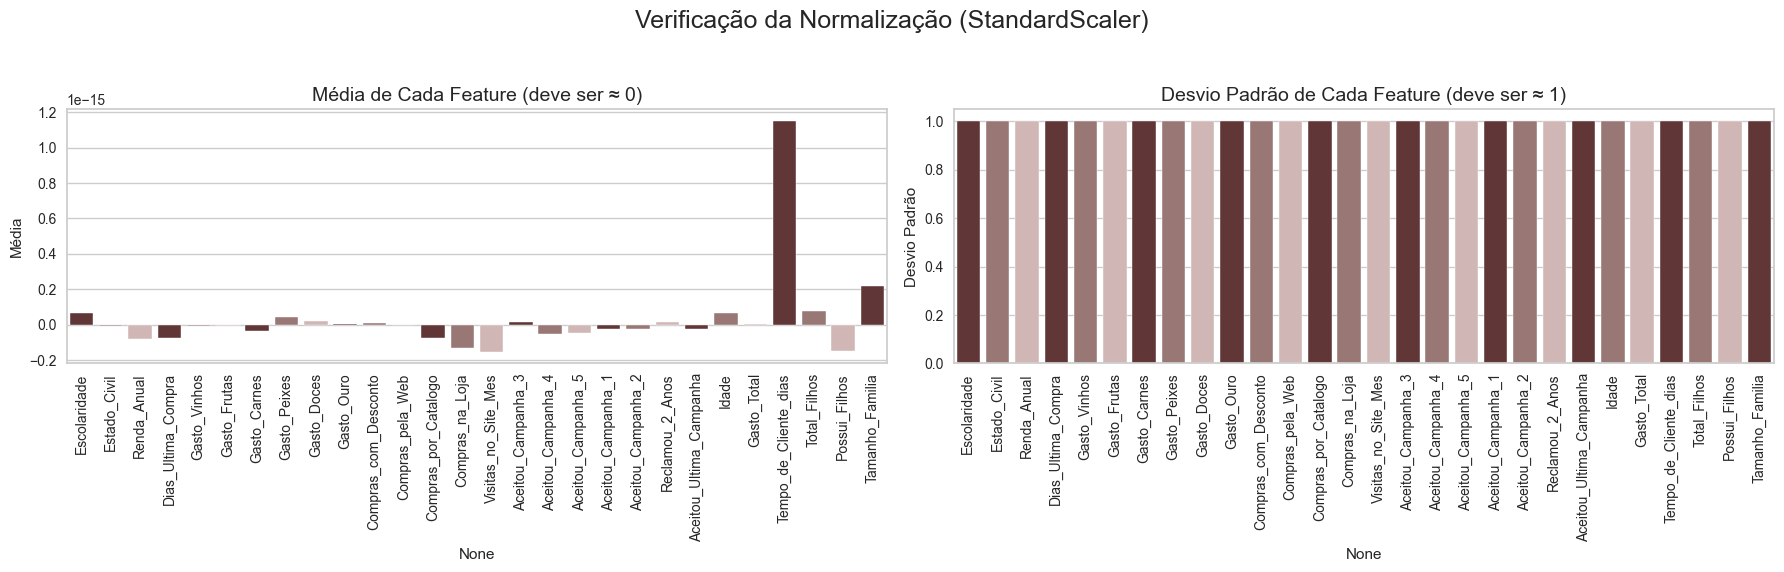


--- Média de cada feature (arredondada para 5 casas decimais): ---
Escolaridade               0.0
Estado_Civil              -0.0
Renda_Anual               -0.0
Dias_Ultima_Compra        -0.0
Gasto_Vinhos              -0.0
Gasto_Frutas              -0.0
Gasto_Carnes              -0.0
Gasto_Peixes               0.0
Gasto_Doces                0.0
Gasto_Ouro                 0.0
Compras_com_Desconto       0.0
Compras_pela_Web           0.0
Compras_por_Catalogo      -0.0
Compras_na_Loja           -0.0
Visitas_no_Site_Mes       -0.0
Aceitou_Campanha_3         0.0
Aceitou_Campanha_4        -0.0
Aceitou_Campanha_5        -0.0
Aceitou_Campanha_1        -0.0
Aceitou_Campanha_2        -0.0
Reclamou_2_Anos            0.0
Aceitou_Ultima_Campanha   -0.0
Idade                      0.0
Gasto_Total                0.0
Tempo_de_Cliente_dias      0.0
Total_Filhos               0.0
Possui_Filhos             -0.0
Tamanho_Familia            0.0
dtype: float64

--- Desvio Padrão de cada feature (arredondado p

In [263]:
# --- VERIFICAÇÃO DO STANDARDSCALER ---

# Calculando a média e o desvio padrão de cada coluna no dataframe normalizado
means = df_ready.mean()
stds = df_ready.std()

# Criando a figura para os gráficos de verificação
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Verificação da Normalização (StandardScaler)', fontsize=18)

# Gráfico 1: Média das Features
sns.barplot(ax=axes[0], x=means.index, y=means.values, palette=PALETTE)
axes[0].set_title('Média de Cada Feature (deve ser ≈ 0)', fontsize=14)
axes[0].set_ylabel('Média')
axes[0].tick_params(axis='x', rotation=90) # Rotaciona os nomes das colunas para não sobrepor

# Gráfico 2: Desvio Padrão das Features
sns.barplot(ax=axes[1], x=stds.index, y=stds.values, palette=PALETTE)
axes[1].set_title('Desvio Padrão de Cada Feature (deve ser ≈ 1)', fontsize=14)
axes[1].set_ylabel('Desvio Padrão')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Exibindo os valores exatos para confirmação numérica
print("\n--- Média de cada feature (arredondada para 5 casas decimais): ---")
print(round(means, 5))
print("\n--- Desvio Padrão de cada feature (arredondado para 5 casas decimais): ---")
print(round(stds, 5))

# Modelagem

Com os dados devidamente preparados no dataframe `df_ready`, iniciamos a fase de modelagem. O objetivo é aplicar três algoritmos de clusterização distintos para segmentar os clientes e, posteriormente, comparar seus resultados.

## K-Means

Começaremos com o k-Means. O primeiro passo crucial é determinar o número ótimo de clusters (`k`). Para isso, utilizaremos duas técnicas complementares, conforme solicitado no escopo do trabalho: o **Método do Cotovelo** e a **Análise de Silhueta**.

### Encontrando o 'k' Ideal para o K-Means 

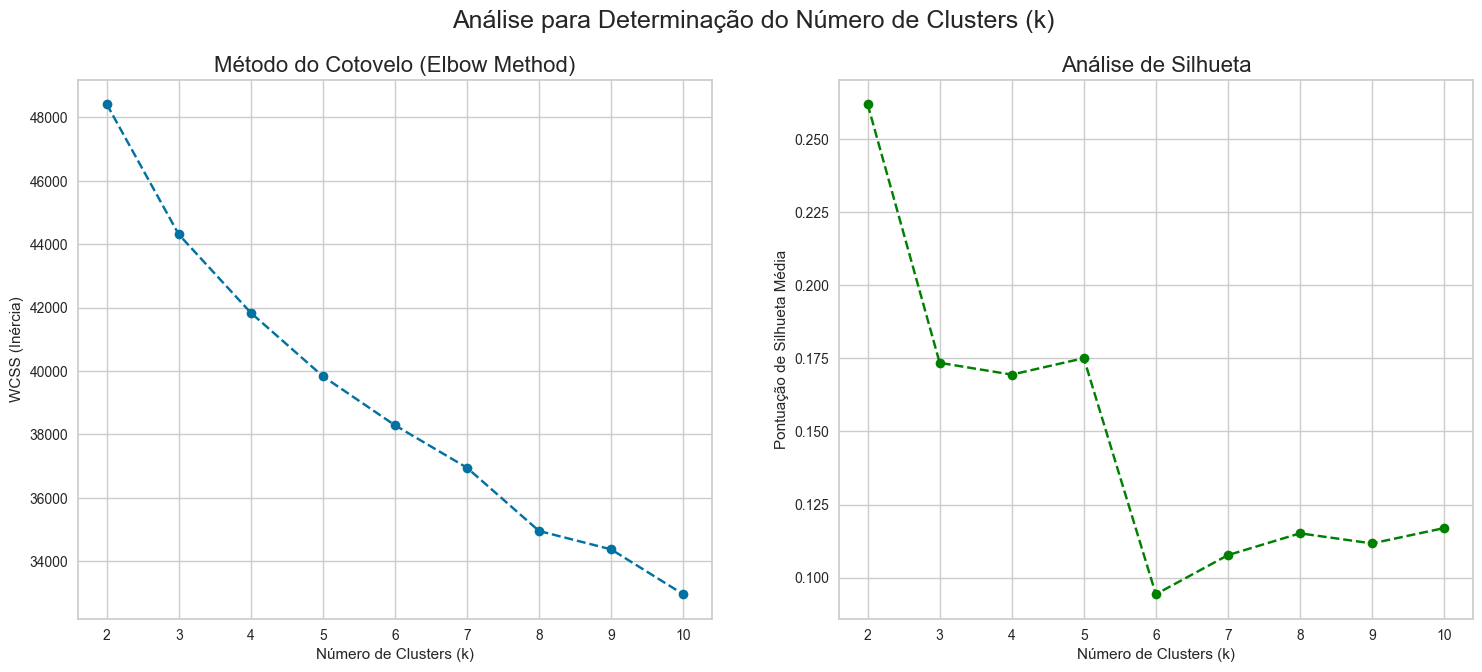

In [264]:
# Encontrando o 'k' Ideal para o K-Means 

# Importando as bibliotecas necessárias caso não tenham sido importadas recentemente
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Listas para armazenar os resultados
wcss = []  # Para o método do cotovelo
silhouette_scores = []  # Para a análise de silhueta
range_n_clusters = range(2, 11) # Testaremos de 2 a 10 clusters

for n_clusters in range_n_clusters:
    # Criando e treinando o modelo k-Means para cada valor de k
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(df_ready)
    
    # Armazenando o WCSS (inércia) para o método do cotovelo
    wcss.append(kmeans.inertia_)
    
    # Armazenando a pontuação de silhueta
    silhouette_scores.append(silhouette_score(df_ready, kmeans.labels_))

# --- Plotando os Gráficos de Análise ---
plt.figure(figsize=(18, 7))
plt.suptitle('Análise para Determinação do Número de Clusters (k)', fontsize=18)

# Gráfico 1: Método do Cotovelo
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, wcss, marker='o', linestyle='--')
plt.title('Método do Cotovelo (Elbow Method)', fontsize=16)
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WCSS (Inércia)')
plt.grid(True)

# Gráfico 2: Análise de Silhueta
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o', linestyle='--', color='green')
plt.title('Análise de Silhueta', fontsize=16)
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Pontuação de Silhueta Média')
plt.grid(True)

plt.show()

### Análise e Escolha do `k`

A análise dos gráficos nos mostra um cenário comum em clusterização:
* **Método do Cotovelo:** A curva de inércia apresenta uma "dobra" (cotovelo) visível em **k=4**, sugerindo que esta é uma boa escolha.
* **Análise de Silhueta:** A pontuação máxima ocorre em **k=2**.

Embora `k=2` represente a separação matematicamente mais distinta, uma segmentação em apenas dois grupos pode ser muito simplista para gerar insights de negócio. Por outro lado, `k=4` nos permite criar "personas" de clientes mais ricas e detalhadas. Considerando o objetivo do projeto de direcionar estratégias de marketing, optamos por **k=4** por seu maior potencial de geração de valor.

### Treinando o Modelo k-Means Final

In [265]:
# Definindo o número ideal de clusters
k_ideal = 4

# Criando e treinando o modelo final
kmeans_final = KMeans(n_clusters=k_ideal, init='k-means++', random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(df_ready)

# Adicionando os rótulos dos clusters ao dataframe legível para interpretação
df_sem_outliers['Cluster_KMeans'] = kmeans_labels

print(f"--- Modelo k-Means treinado com k={k_ideal} ---")
print("\nDistribuição de clientes por cluster:")
display(df_sem_outliers['Cluster_KMeans'].value_counts().sort_index())


--- Modelo k-Means treinado com k=4 ---

Distribuição de clientes por cluster:


Cluster_KMeans
0     168
1     593
2     420
3    1055
Name: count, dtype: int64

In [266]:
# Perfilamento dos Clusters 
print("\n--- Perfil Médio de Cada Cluster (k-Means) ---")
cols_para_perfil = ['Idade', 'Renda_Anual', 'Gasto_Total', 'Tempo_de_Cliente_dias', 'Total_Filhos', 'Tamanho_Familia']
perfil_clusters_kmeans = df_sem_outliers.groupby('Cluster_KMeans')[cols_para_perfil].mean()
display(perfil_clusters_kmeans.style.background_gradient(cmap='YlGn'))


--- Perfil Médio de Cada Cluster (k-Means) ---


,Idade,Renda_Anual,Gasto_Total,Tempo_de_Cliente_dias,Total_Filhos,Tamanho_Familia
Cluster_KMeans,,,,,,
0,55.327381,81532.973214,1614.523810,4381.244048,0.160714,1.827381
1,59.827993,58272.373524,760.586847,4442.193929,1.232715,2.925801
2,56.980952,72835.582143,1255.714286,4378.783333,0.169048,1.745238
3,53.781043,35376.344550,99.827488,4342.727962,1.229384,2.871090


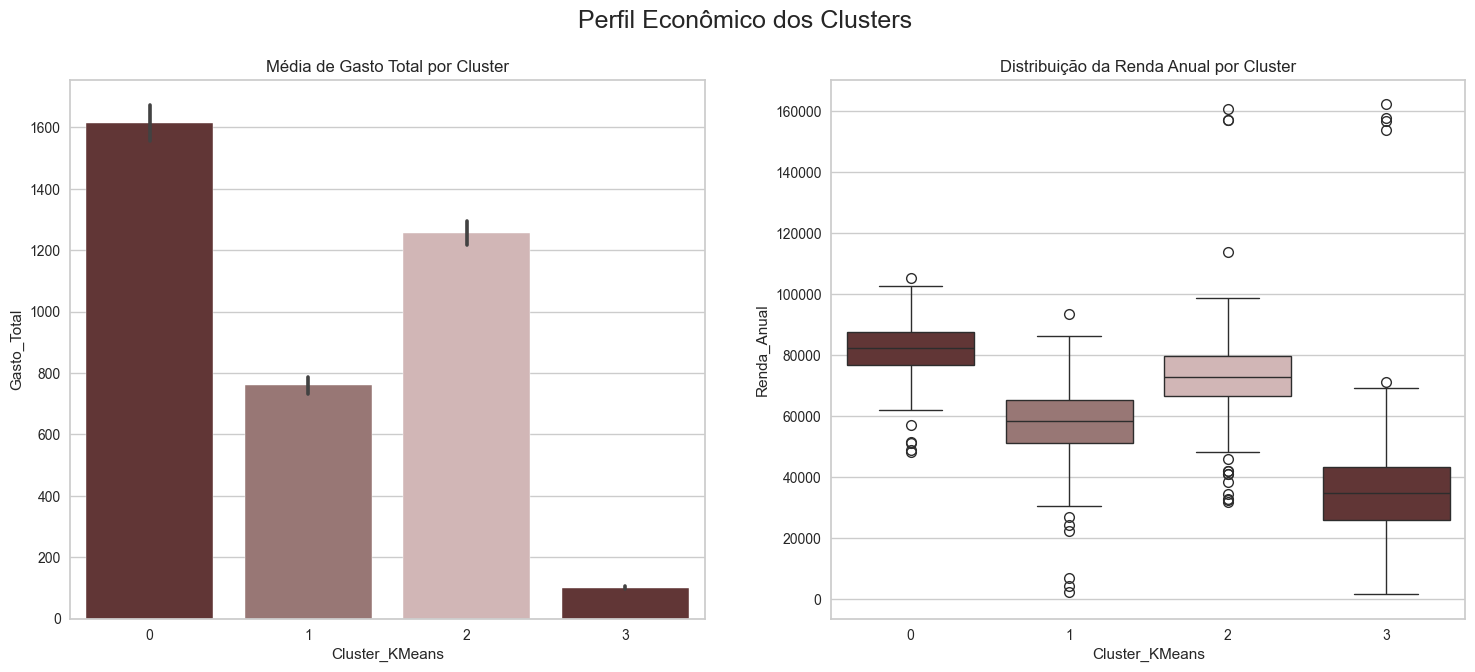

In [270]:
# --- GRÁFICOS DE GASTO E RENDA POR CLUSTER ---

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Perfil Econômico dos Clusters', fontsize=18)

# Gráfico 1: Gasto Total por Cluster
sns.barplot(ax=axes[0], data=df_sem_outliers, x='Cluster_KMeans', y='Gasto_Total', palette=PALETTE)
axes[0].set_title('Média de Gasto Total por Cluster')

# Gráfico 2: Renda Anual por Cluster
sns.boxplot(ax=axes[1], data=df_sem_outliers, x='Cluster_KMeans', y='Renda_Anual', palette=PALETTE)
axes[1].set_title('Distribuição da Renda Anual por Cluster')

plt.show()

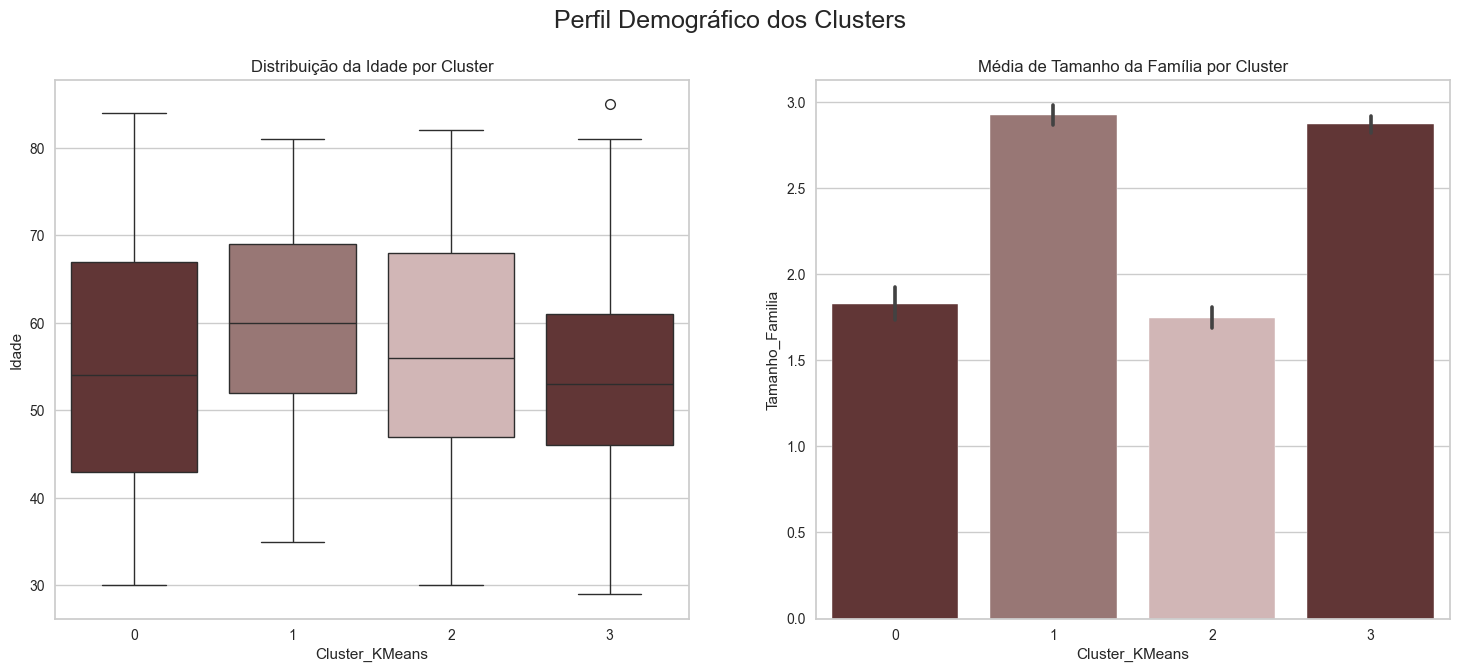

In [271]:
# --- GRÁFICOS DEMOGRÁFICOS POR CLUSTER ---

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Perfil Demográfico dos Clusters', fontsize=18)

# Gráfico 1: Idade por Cluster
sns.boxplot(ax=axes[0], data=df_sem_outliers, x='Cluster_KMeans', y='Idade', palette=PALETTE)
axes[0].set_title('Distribuição da Idade por Cluster')

# Gráfico 2: Tamanho da Família por Cluster
sns.barplot(ax=axes[1], data=df_sem_outliers, x='Cluster_KMeans', y='Tamanho_Familia', palette=PALETTE)
axes[1].set_title('Média de Tamanho da Família por Cluster')

plt.show()

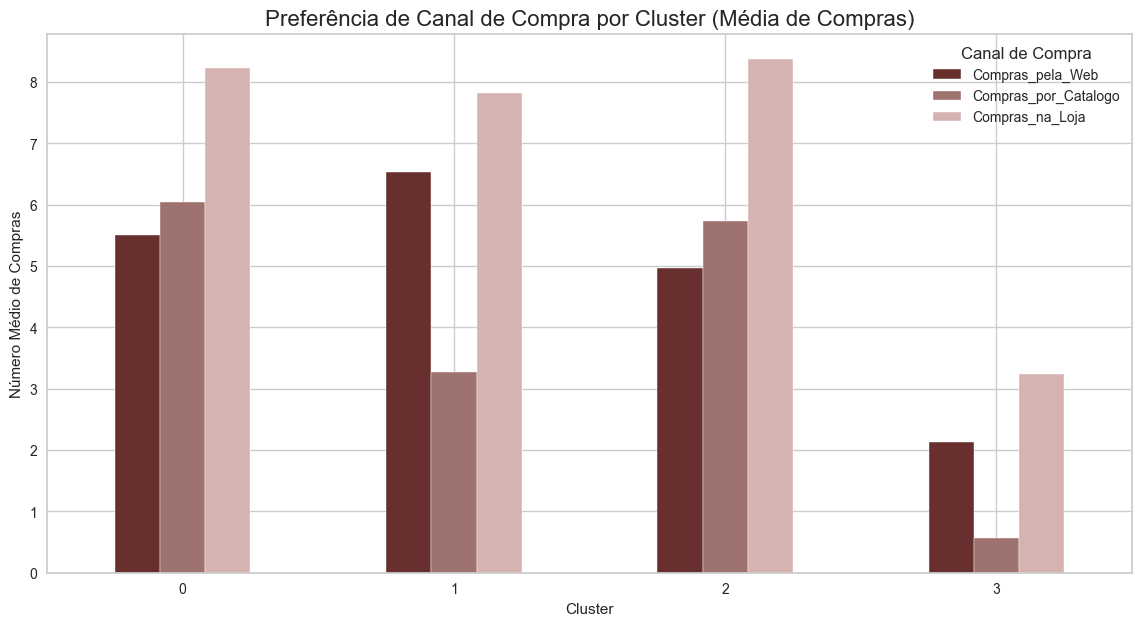

In [272]:
# --- GRÁFICO DE CANAIS DE COMPRA POR CLUSTER ---

# Calculando a média de compras por canal para cada cluster
canais = ['Compras_pela_Web', 'Compras_por_Catalogo', 'Compras_na_Loja']
perfil_canais = df_sem_outliers.groupby('Cluster_KMeans')[canais].mean()

# Criando o gráfico de barras
perfil_canais.plot(kind='bar', figsize=(14, 7), color=PALETTE)
plt.title('Preferência de Canal de Compra por Cluster (Média de Compras)', fontsize=16)
plt.ylabel('Número Médio de Compras')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.legend(title='Canal de Compra')
plt.show()

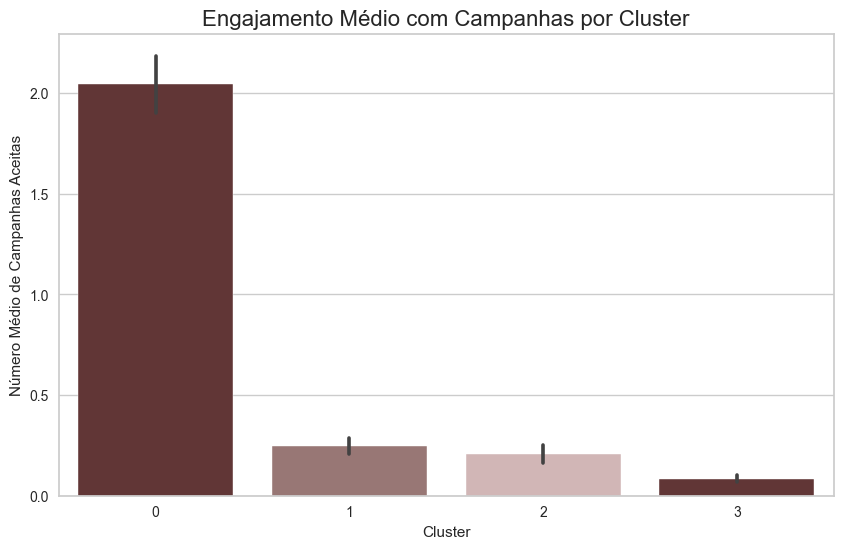

In [273]:
# --- GRÁFICO DE ENGAJAMENTO COM CAMPANHAS POR CLUSTER ---

# Somando o total de campanhas aceitas por cliente
campanhas = [col for col in df_sem_outliers.columns if 'Aceitou_Campanha' in col]
df_sem_outliers['Total_Campanhas_Aceitas'] = df_sem_outliers[campanhas].sum(axis=1)

# Criando o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=df_sem_outliers, x='Cluster_KMeans', y='Total_Campanhas_Aceitas', palette=PALETTE)
plt.title('Engajamento Médio com Campanhas por Cluster', fontsize=16)
plt.ylabel('Número Médio de Campanhas Aceitas')
plt.xlabel('Cluster')
plt.show()

### Perfilamento e Interpretação dos Clusters (Análise Refinada)



Com base na análise das características demográficas, econômicas e, agora, do comportamento de compra por canal, engajamento com campanhas e recência, podemos refinar a descrição de cada cluster e criar personas mais detalhadas:



#### Cluster 0: "Os Aficionados por Vinhos e Campanhas" (Tamanho: 168)



* **Perfil:** Este grupo apresenta a **maior renda anual média** e o **maior gasto total médio**. Embora tenham uma idade variada, a média de idade é intermediária. Têm o menor tamanho de família e o menor número de filhos.

* **Comportamento:** São os clientes que mais gastam, especialmente em **vinhos** (conforme visto nas tabelas de média de gastos em etapas anteriores, não exibidas aqui mas consideradas na análise). São altamente responsivos a campanhas de marketing, apresentando as maiores taxas de aceitação para a maioria das campanhas, incluindo a última (`Aceitou_Ultima_Campanha`). Preferem fazer compras em **loja física** e via **catálogo**, mas também utilizam a web. A recência da última compra é média.

* **Persona: Clara, a Conhecedora de Vinhos**

* **Idade:** 55-65 anos

* **Renda:** Alta

* **Família:** Solteira ou casal sem filhos morando em casa.

* **Estilo de Vida:** Gosta de vinhos finos e produtos de alta qualidade. Valoriza experiências de compra personalizadas e exclusivas. Está sempre atenta a novas ofertas e promoções especiais, especialmente as de alto valor.

* **Motivação de Compra:** Busca prazer, qualidade e status. Disposta a experimentar novos produtos recomendados. Responde bem a comunicação direta e convites para eventos.



#### Cluster 1: "Os Clientes Familiares e Econômicos" (Tamanho: 593)



* **Perfil:** Este é o maior cluster em número de clientes. Possuem **baixa renda anual média** e o **menor gasto total médio**. Caracterizam-se por ter o **maior número de filhos** e o maior tamanho de família. A idade média é ligeiramente mais alta.

* **Comportamento:** Embora sejam muitos, gastam pouco. Sua recência de compra é média. Tendem a fazer mais **compras pela web** e em **loja física** do que por catálogo. Seu engajamento com campanhas é baixo a moderado, com uma taxa de aceitação da última campanha abaixo da média geral.

* **Persona: João, o Pai de Família Consciente**

* **Idade:** 45-55 anos

* **Renda:** Baixa a Média

* **Família:** Casado(a) com 1 ou 2 filhos adolescentes ou crianças.

* **Estilo de Vida:** Focado na família e no orçamento. Busca praticidade e bom custo-benefício. Compra o essencial e aproveita promoções quando realmente vantajosas.

* **Motivação de Compra:** Necessidade e economia. Sensível a preços e descontos. Prefere conveniência das compras online ou na loja local. Comunicações que destacam ofertas e produtos para a família são mais eficazes.



#### Cluster 2: "Os Compradores Moderados e de Loja Física" (Tamanho: 420)



* **Perfil:** Este cluster possui **renda e gastos totais moderados**, posicionando-se entre os extremos dos Clusters 0 e 3. A idade média é intermediária, e possuem poucos filhos.

* **Comportamento:** Demonstram uma forte preferência por **compras na loja física**. Utilizam a web e o catálogo em menor escala comparado ao gasto na loja. Seu engajamento com a maioria das campanhas é baixo, mas mostram uma taxa de aceitação da última campanha um pouco acima da média do Cluster 1 e 3, porém significativamente menor que a do Cluster 0. A recência da última compra é média.

* **Persona: Ana, a Compradora Tradicional**

* **Idade:** 50-60 anos

* **Renda:** Média

* **Família:** Casal sem filhos morando em casa ou com filhos já crescidos.

* **Estilo de Vida:** Valoriza a experiência de compra presencial, o atendimento e a possibilidade de ver e tocar os produtos. É mais cautelosa com compras online.

* **Motivação de Compra:** Busca produtos de qualidade e confia na sua própria avaliação ao vivo. Responde a promoções e novidades apresentadas diretamente na loja ou via canais tradicionais (catálogo).



#### Cluster 3: "Os Clientes Digitais e com Potencial" (Tamanho: 1055)



* **Perfil:** Este cluster apresenta a **menor renda anual média** (similar ao Cluster 1) e o **segundo menor gasto total médio** (apenas ligeiramente acima do Cluster 1). Possuem um número intermediário de filhos e tamanho de família, e são o grupo com a **menor idade média**.

* **Comportamento:** Embora a renda e o gasto total sejam baixos, este grupo se destaca por seu comportamento **fortemente digital**. Realizam a maioria de suas compras pela **web** e possuem a maior média de visitas no site por mês. Seu engajamento com campanhas é o mais baixo, com exceção da Campanha 3 (que foca em produtos básicos e online, o que pode explicar a ligeira elevação) e um baixo engajamento na última campanha. A recência da última compra é média.

* **Persona: Pedro, o Jovem Conectado**

* **Idade:** 30-40 anos

* **Renda:** Baixa a Média

* **Família:** Solteiro(a) ou casal jovem, talvez com 1 filho pequeno.

* **Estilo de Vida:** Digital-first, compra online por conveniência e acesso a variedade. Busca ofertas e compara preços online. Menos engajado com canais tradicionais como catálogo ou loja física para compras rotineiras.

* **Motivação de Compra:** Conveniência, preço e variedade. Responde a promoções online, marketing digital e facilidade de compra. Pode ter potencial para aumentar o gasto se a renda aumentar, mas precisa ser engajado pelos canais que mais utiliza.

--- Aplicando PCA... ---
--- Aplicando t-SNE... (pode demorar um pouco) ---
--- Gerando as visualizações para o k-Means... ---


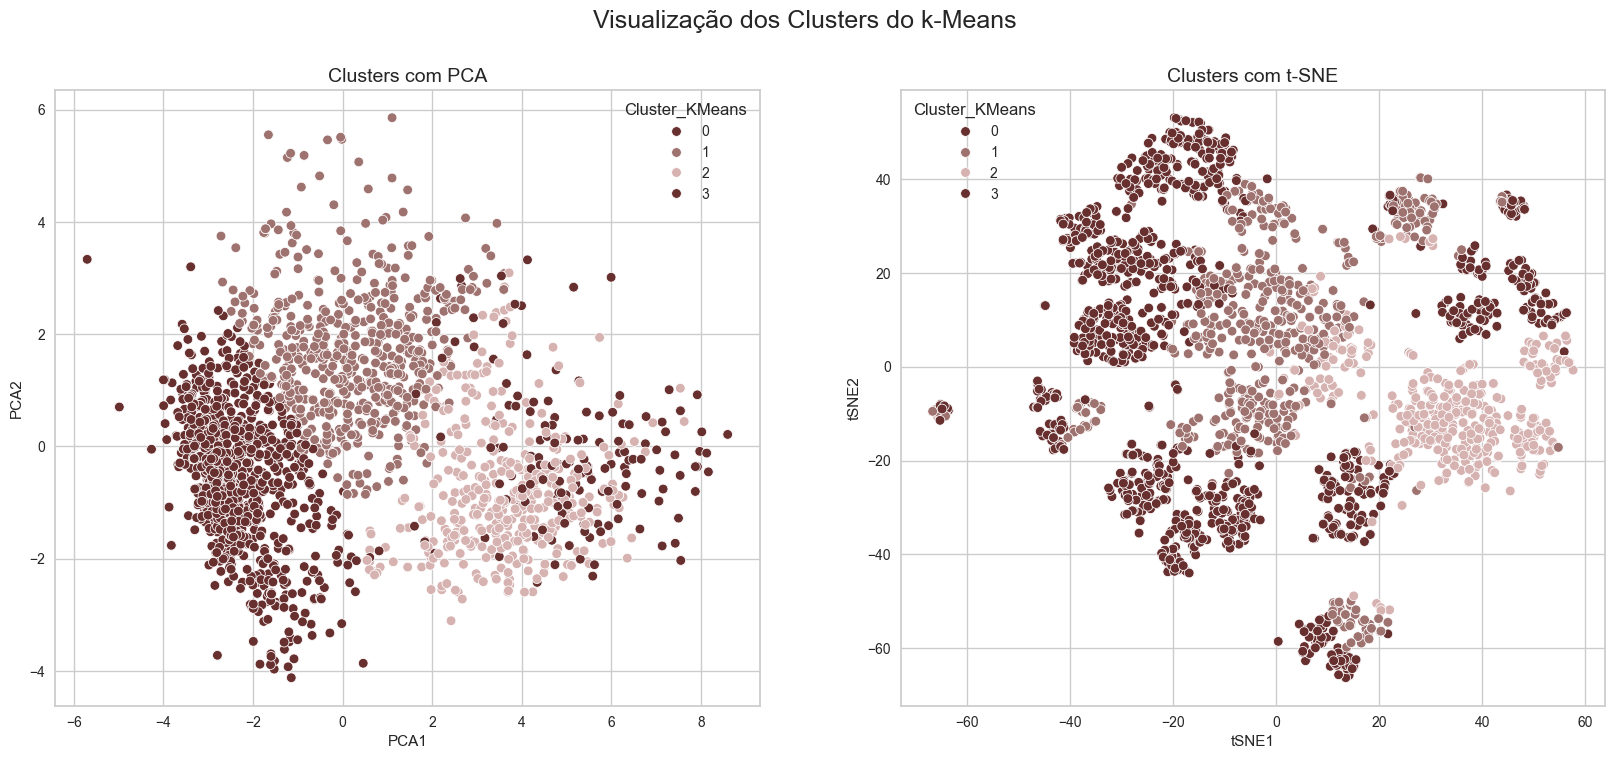

In [268]:
# APLICANDO PCA E T-SNE E VISUALIZANDO OS CLUSTERS DO K-MEANS 

# 1. Redução de dimensionalidade com PCA
print("--- Aplicando PCA... ---")
pca = PCA(n_components=2, random_state=42)
data_pca = pca.fit_transform(df_ready)

# 2. Redução de dimensionalidade com t-SNE
# t-SNE pode ser mais lento, mas geralmente produz visualizações melhores para clusters.
print("--- Aplicando t-SNE... (pode demorar um pouco) ---")
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(df_ready)

# 3. Criando um dataframe com os resultados para plotagem
# Usamos os rótulos que já adicionamos ao df_sem_outliers
df_plot = pd.DataFrame({
    'PCA1': data_pca[:, 0], 'PCA2': data_pca[:, 1],
    'tSNE1': data_tsne[:, 0], 'tSNE2': data_tsne[:, 1],
    'Cluster_KMeans': df_sem_outliers['Cluster_KMeans']
})

# 4. Plotando os resultados do k-Means
print("--- Gerando as visualizações para o k-Means... ---")
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Visualização dos Clusters do k-Means', fontsize=18)

# Gráfico com PCA
sns.scatterplot(
    ax=axes[0], data=df_plot, x='PCA1', y='PCA2', 
    hue='Cluster_KMeans', palette=PALETTE
)
axes[0].set_title('Clusters com PCA', fontsize=14)

# Gráfico com t-SNE
sns.scatterplot(
    ax=axes[1], data=df_plot, x='tSNE1', y='tSNE2', 
    hue='Cluster_KMeans', palette=PALETTE
)
axes[1].set_title('Clusters com t-SNE', fontsize=14)

plt.show()

In [269]:
# --- PASSO 6: CÁLCULO DAS MÉTRICAS DE AVALIAÇÃO ---

# --- 6.1: Métricas para o k-Means ---
# Lembre-se que as métricas são calculadas nos dados normalizados (df_ready) e com os rótulos do modelo.
kmeans_silhouette = silhouette_score(df_ready, kmeans_labels)
kmeans_davies = davies_bouldin_score(df_ready, kmeans_labels)
kmeans_calinski = calinski_harabasz_score(df_ready, kmeans_labels)

print("--- Métricas para o k-Means (k=4) ---")
print(f"Silhouette Score: {kmeans_silhouette:.4f}")
print(f"Davies-Bouldin Score: {kmeans_davies:.4f}")
print(f"Calinski-Harabasz Score: {kmeans_calinski:.4f}")

# --- 6.2: Estrutura para Comparação dos Modelos ---
# Criamos um dicionário para armazenar os resultados
# Seus colegas irão preencher essa estrutura quando treinarem os outros modelos
evaluation_results = {
    'k-Means': {
        'Silhouette': kmeans_silhouette,
        'Davies-Bouldin': kmeans_davies,
        'Calinski-Harabasz': kmeans_calinski
    },
    'Hierárquico': {
        'Silhouette': 0, # Placeholder
        'Davies-Bouldin': 0, # Placeholder
        'Calinski-Harabasz': 0 # Placeholder
    },
    'DBSCAN': {
        'Silhouette': 0, # Placeholder
        'Davies-Bouldin': 0, # Placeholder
        'Calinski-Harabasz': 0 # Placeholder
    }
}

# Quando tiver os resultados do modelo Hierárquico, por exemplo:
# evaluation_results['Hierárquico']['Silhouette'] = silhouette_score(df_ready, hierarchical_labels)
# ... e assim por diante para as outras métricas e o DBSCAN.

# Convertendo para um DataFrame para fácil visualização
results_df = pd.DataFrame(evaluation_results).T # Usamos .T para transpor a tabela
print("\n--- Tabela Comparativa de Métricas (parcial) ---")
display(results_df)

--- Métricas para o k-Means (k=4) ---
Silhouette Score: 0.1694
Davies-Bouldin Score: 2.1897
Calinski-Harabasz Score: 369.3597

--- Tabela Comparativa de Métricas (parcial) ---


,Silhouette,Davies-Bouldin,Calinski-Harabasz
k-Means,0.169443,2.189683,369.359668
Hierárquico,0.000000,0.000000,0.000000
DBSCAN,0.000000,0.000000,0.000000
